In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.model_selection import learning_curve

from mlxtend.plotting import plot_learning_curves
from yellowbrick.model_selection import LearningCurve

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report


import pickle

import warnings


warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('campaign_clean.csv').drop('Unnamed: 0', axis=1)
df.head(3)

,age,job,marital,education,housing,loan,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,label
0,56,housemaid,married,basic.4y,no,no,may,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,no,no,may,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,yes,no,may,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


# Hyperparameter Tuning

- Logistic Regression = Polynomial - Selection Feature
- Decision Tree = Selection Feature
- Random Forest = Selectiion Feature

## Data Splitting

In [12]:
X = df.drop('label', axis=1)
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=2020, test_size=.2)

In [157]:
### Pipeline
num_scale_trans = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])


num_poly_trans = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3))])


cat_trans = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])




### Transformer
preprocessor_1 = ColumnTransformer([
        ('num_scale_trans', num_scale_trans,['emp.var.rate','euribor3m','nr.employed','cons.price.idx','cons.conf.idx','age', 'campaign', 'pdays', 'previous']),
        ('cat', cat_trans, ['marital','housing','loan', 'poutcome','job', 'education', 'month'])
])
     
    
preprocessor_2 = ColumnTransformer([
        ('cat', cat_trans, ['marital','housing','loan', 'poutcome','job', 'education', 'month'])])


preprocessor_1_poly = ColumnTransformer([
        ('num_scale_trans', num_scale_trans,['emp.var.rate','euribor3m','nr.employed','cons.price.idx','cons.conf.idx','age', 'campaign', 'pdays', 'previous']),
        ('num_poly_trans', num_poly_trans,['emp.var.rate','euribor3m','nr.employed','cons.price.idx','cons.conf.idx','age', 'campaign', 'pdays', 'previous']),
        ('cat', cat_trans, ['marital','housing','loan', 'poutcome','job', 'education', 'month'])
])
     
    


In [82]:
logreg_poly = Pipeline(steps=[('preprocessor_1_poly', preprocessor_1_poly),
                                ('logreg', LogisticRegression(random_state = 2020))])


logreg_select = Pipeline(steps=[('preprocessor_1', preprocessor_1),
                                ('select', SelectPercentile(percentile=30)),
                                ('logreg', LogisticRegression(random_state = 2020))])


logreg_poly_select = Pipeline(steps=[('preprocessor_1_poly', preprocessor_1_poly),
                                ('select', SelectPercentile(percentile=30)),
                                ('logreg', LogisticRegression(random_state = 2020))])


logreg_select_poly = Pipeline(steps=[('preprocessor_1', preprocessor_1),
                                ('select', SelectPercentile(percentile=30)),
                                ('poly', PolynomialFeatures(degree=3)),
                                ('logreg', LogisticRegression(random_state = 2020))])


dtree_select = Pipeline(steps=[('preprocessor_2', preprocessor_2),
                               ('select', SelectPercentile(percentile=30)),
                               ('dtree', DecisionTreeClassifier(random_state = 2020))])


ranfor_select = Pipeline(steps=[('preprocessor_2_select', preprocessor_2),
                                ('select', SelectPercentile(percentile=30)),
                                ('ranfor', RandomForestClassifier(random_state = 2020))])

## Logistic Regression

### Poly Logistic Regression

In [38]:
## Logistic Regression

# Hyperparameter
hyperparam_space = {
    'logreg__solver':['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'logreg__penalty':['l1', 'l2', 'elasticnet', 'none'],
    'logreg__max_iter':[1, 10, 100, 1000, 10000]
}

# Cross Validation
skfold = StratifiedKFold(n_splits=5)

# Searching with GridSearch - Cross Validation
logreg_poly_grid_search = GridSearchCV(
    logreg_poly,
    param_grid = hyperparam_space,
    cv = skfold,
    n_jobs=-1,
    scoring='precision'
)

In [28]:
logreg_poly_grid_search.fit(X_train, y_train)
print('Logreg Poly Best Params:',logreg_poly_grid_search.best_params_)
print('Logreg Poly Params:',logreg_poly_grid_search.best_score_)

Logreg Poly Best Params: {'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Logreg Poly Params: 0.6754362521352755


In [30]:
logreg_poly_tuned =  Pipeline(steps=[('preprocessor_1_poly', preprocessor_1_poly),
                                ('logreg', LogisticRegression(solver='newton-cg', penalty='l2', max_iter=100, random_state = 2020))])
logreg_poly_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_1_poly',
                 ColumnTransformer(transformers=[('num_scale_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'age',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('num_poly_trans',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['emp.va

In [31]:
y_pred_logreg_poly_tuned = logreg_poly_tuned.predict(X_test)
print(classification_report(y_test, y_pred_logreg_poly_tuned))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6797
           1       0.66      0.21      0.32       852

    accuracy                           0.90      7649
   macro avg       0.79      0.60      0.63      7649
weighted avg       0.88      0.90      0.88      7649



### Select Logistic Regression

In [33]:
## Logistic Regression

# Hyperparameter
hyperparam_space = {
    'logreg__solver':['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'logreg__penalty':['l1', 'l2', 'elasticnet', 'none'],
    'logreg__max_iter':[1, 10, 100, 1000, 10000]
}

# Cross Validation
skfold = StratifiedKFold(n_splits=5)

# Searching with GridSearch - Cross Validation
logreg_select_grid_search = GridSearchCV(
    logreg_select,
    param_grid = hyperparam_space,
    cv = skfold,
    n_jobs=-1,
    scoring='precision'
)

In [35]:
logreg_select_grid_search.fit(X_train, y_train)
print('Logreg Select Best Params:',logreg_select_grid_search.best_params_)
print('Logreg Select Params:',logreg_select_grid_search.best_score_)

Logreg Select Best Params: {'logreg__max_iter': 1, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Logreg Select Params: 0.7106076432185388


In [36]:
logreg_select_tuned = Pipeline(steps=[('preprocessor_1', preprocessor_1),
                                ('select', SelectPercentile(percentile=30)),
                                ('logreg', LogisticRegression(solver='newton-cg', penalty='l2', max_iter=100,random_state = 2020))])

logreg_select_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_1',
                 ColumnTransformer(transformers=[('num_scale_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'age',
                                                   'campaign', 'pdays',
                                                   'previous'])])),
                ('select', SelectPercentile(percentile=30)),
                ('logreg',
                 LogisticRegression(random_state=2020, solver='newton-cg'))])

In [37]:
y_pred_logreg_select_tuned = logreg_select_tuned.predict(X_test)
print(classification_report(y_test, y_pred_logreg_select_tuned))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6797
           1       0.70      0.19      0.30       852

    accuracy                           0.90      7649
   macro avg       0.80      0.59      0.62      7649
weighted avg       0.88      0.90      0.87      7649



### Poly + Select Logistic Regression

In [39]:
## Logistic Regression

# Hyperparameter
hyperparam_space = {
    'logreg__solver':['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'logreg__penalty':['l1', 'l2', 'elasticnet', 'none'],
    'logreg__max_iter':[1, 10, 100, 1000, 10000]
}

# Cross Validation
skfold = StratifiedKFold(n_splits=5)

# Searching with GridSearch - Cross Validation
logreg_poly_select_grid_search = GridSearchCV(
    logreg_poly_select,
    param_grid = hyperparam_space,
    cv = skfold,
    n_jobs=-1,
    scoring='precision'
)

In [40]:
logreg_poly_select_grid_search.fit(X_train, y_train)
print('Logreg Select Best Params:',logreg_poly_select_grid_search.best_params_)
print('Logreg Select Params:',logreg_poly_select_grid_search.best_score_)

Logreg Select Best Params: {'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
Logreg Select Params: 0.7088836213579087


In [41]:
logreg_poly_select_tuned = Pipeline(steps=[('preprocessor_1_poly', preprocessor_1_poly),
                                ('select', SelectPercentile(percentile=30)),
                                ('logreg', LogisticRegression(solver='newton-cg', penalty='l2', max_iter=100,random_state = 2020))])

logreg_poly_select_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_1_poly',
                 ColumnTransformer(transformers=[('num_scale_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'age',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('num_poly_trans',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['emp.va

In [42]:
y_pred_logreg_poly_select_tuned = logreg_poly_select_tuned.predict(X_test)
print(classification_report(y_test, y_pred_logreg_poly_select_tuned))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6797
           1       0.71      0.18      0.29       852

    accuracy                           0.90      7649
   macro avg       0.81      0.59      0.62      7649
weighted avg       0.88      0.90      0.87      7649



### Select + Poly Logistic Regression

In [46]:
## Logistic Regression

# Hyperparameter
hyperparam_space = {
    'logreg__solver':['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'logreg__penalty':['l1', 'l2', 'elasticnet', 'none'],
    'logreg__max_iter':[1, 10, 100, 1000, 10000]
}

# Cross Validation
skfold = StratifiedKFold(n_splits=5)

# Searching with GridSearch - Cross Validation
logreg_select_poly_grid_search = GridSearchCV(
    logreg_select_poly,
    param_grid = hyperparam_space,
    cv = skfold,
    n_jobs=-1,
    scoring='precision'
)

In [47]:
logreg_select_poly_grid_search.fit(X_train, y_train)
print('Logreg Select Poly Best Params:',logreg_select_poly_grid_search.best_params_)
print('Logreg Select Poly Params:',logreg_select_poly_grid_search.best_score_)

Logreg Select Best Params: {'logreg__max_iter': 100, 'logreg__penalty': 'none', 'logreg__solver': 'sag'}
Logreg Select Params: 0.7242029175198936


In [158]:
logreg_select_poly_tuned = Pipeline(steps=[('preprocessor_1', preprocessor_1),
                                ('select', SelectPercentile(percentile=30)),
                                ('poly', PolynomialFeatures(degree=3)),
                                ('logreg', LogisticRegression(solver='sag', penalty='none', max_iter=100,random_state = 2020))])

logreg_select_poly_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_1',
                 ColumnTransformer(transformers=[('num_scale_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['emp.var.rate', 'euribor3m',
                                                   'nr.employed',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'age',
                                                   'campaign', 'pdays',
                                                   'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marital', 

In [159]:
y_pred_logreg_select_poly_tuned = logreg_select_poly_tuned.predict(X_test)
print(classification_report(y_test, y_pred_logreg_select_poly_tuned))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      6797
           1       0.64      0.23      0.34       852

    accuracy                           0.90      7649
   macro avg       0.78      0.61      0.64      7649
weighted avg       0.88      0.90      0.88      7649



### Select Decision Tree Regression

In [104]:
# Hyperparameter
hyperparam_space = {
    'dtree__criterion':['gini', 'entropy'],
    'dtree__splitter':['best', 'random'],
    'dtree__max_features':['auto', 'sqrt', 'log2', 'none'],
    'dtree__class_weight':['balanced', 'none'],
    'dtree__min_samples_split':[2,3,4,5],
    'dtree__max_depth':[3,5,7]
}

# Cross Validation
skfold = StratifiedKFold(n_splits=5)

# Searching with GridSearch - Cross Validation
dtree_select_grid_search = GridSearchCV(
    dtree_select,
    param_grid = hyperparam_space,
    cv = skfold,
    n_jobs=-1,
    scoring='precision'
)

In [105]:
dtree_select_grid_search.fit(X_train, y_train)
print('DTree Select Best Params:',dtree_select_grid_search.best_params_)
print('DTree Select Best Score:',dtree_select_grid_search.best_score_)

DTree Select Best Params: {'dtree__class_weight': 'balanced', 'dtree__criterion': 'gini', 'dtree__max_depth': 3, 'dtree__max_features': 'auto', 'dtree__min_samples_split': 2, 'dtree__splitter': 'random'}
DTree Select Best Score: 0.4820014518852641


In [106]:
dtree_select_tuned = Pipeline(steps=[('preprocessor_2', preprocessor_2),
                                ('select', SelectPercentile(percentile=30)),
                                ('dtree', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_features='auto', min_samples_split=2, splitter='random', max_depth=3))])

dtree_select_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_2',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marital', 'housing', 'loan',
                                                   'poutcome', 'job',
                                                   'education', 'month'])])),
                ('select', SelectPercentile(percentile=30)),
                ('dtree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                                        max_features='auto',
                                        splitter='random'))])

In [107]:
y_pred_dtree_select_tuned = dtree_select_tuned.predict(X_test)
print(classification_report(y_test, y_pred_dtree_select_tuned))

              precision    recall  f1-score   support

           0       0.94      0.34      0.50      6797
           1       0.13      0.81      0.23       852

    accuracy                           0.39      7649
   macro avg       0.53      0.58      0.36      7649
weighted avg       0.85      0.39      0.47      7649



### Select Ranfor Regression

In [108]:
# Hyperparameter

hyperparam_space = {
    'ranfor__criterion':['gini', 'entropy'],
    'ranfor__max_features':['auto', 'sqrt', 'log2'],
    'ranfor__class_weight':['balance','balanced_subsample', 'none'],
    'ranfor__min_samples_split':[2,3,4,5],
    'ranfor__max_depth':[3,5,7]
}

# Cross Validation
skfold = StratifiedKFold(n_splits=5)

# Searching with GridSearch - Cross Validation
ranfor_select_grid_search = GridSearchCV(
    ranfor_select,
    param_grid = hyperparam_space,
    cv = skfold,
    n_jobs=-1,
    scoring='precision'
)

In [109]:
ranfor_select_grid_search.fit(X_train, y_train)
print('DTree Select Best Params:',ranfor_select_grid_search.best_params_)
print('DTree Select Best Score:',ranfor_select_grid_search.best_score_)

DTree Select Best Params: {'ranfor__class_weight': 'balanced_subsample', 'ranfor__criterion': 'gini', 'ranfor__max_depth': 7, 'ranfor__max_features': 'auto', 'ranfor__min_samples_split': 2}
DTree Select Best Score: 0.31409834881402476


In [110]:
ranfor_select_tuned = Pipeline(steps=[('preprocessor_2', preprocessor_2),
                                ('select', SelectPercentile(percentile=30)),
                                ('ranfor', RandomForestClassifier(class_weight='balanced_subsample', criterion='gini', max_features='auto', min_samples_split=2, max_depth=7))])

ranfor_select_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_2',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marital', 'housing', 'loan',
                                                   'poutcome', 'job',
                                                   'education', 'month'])])),
                ('select', SelectPercentile(percentile=30)),
                ('ranfor',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=7))])

In [111]:
y_pred_ranfor_select_tuned = ranfor_select_tuned.predict(X_test)
print(classification_report(y_test, y_pred_ranfor_select_tuned))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      6797
           1       0.33      0.52      0.40       852

    accuracy                           0.83      7649
   macro avg       0.63      0.70      0.65      7649
weighted avg       0.87      0.83      0.84      7649



In [160]:
metric_tuned = pd.DataFrame(index = ['Poly Logistic Regression', 'Select Logistic Regression',
                                      'Poly Select Logistic Regression', 'Select Poly Logistic Regression',
                                      'Select Decision Tree', 'Select Ranfor']) 

f1 = []
prec = []
recall = []
acc = []

In [161]:
def evaluationMetrics(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred))
    prec.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))

In [162]:
evaluationMetrics(y_test, y_pred_logreg_poly_tuned)
evaluationMetrics(y_test, y_pred_logreg_select_tuned)
evaluationMetrics(y_test, y_pred_logreg_poly_select_tuned)
evaluationMetrics(y_test, y_pred_logreg_select_poly_tuned)
evaluationMetrics(y_test, y_pred_dtree_select_tuned)
evaluationMetrics(y_test, y_pred_ranfor_select_tuned)

In [163]:
metric_tuned['F1-Score'] = f1
metric_tuned['Recall'] = recall
metric_tuned['Precision'] = prec
metric_tuned['Accuracy'] = acc

In [164]:
metric_tuned = metric_tuned.sort_values(by='Precision', ascending=False).reset_index()

In [165]:
metric_tuned

,index,F1-Score,Recall,Precision,Accuracy
0,Poly Select Logistic Regression,0.291045,0.183099,0.709091,0.900641
1,Select Logistic Regression,0.301748,0.192488,0.697872,0.900771
2,Poly Logistic Regression,0.315130,0.206573,0.664151,0.899987
3,Select Poly Logistic Regression,0.340242,0.231221,0.643791,0.900118
4,Select Ranfor,0.403794,0.524648,0.328194,0.827428
5,Select Decision Tree,0.229698,0.813380,0.133732,0.392339


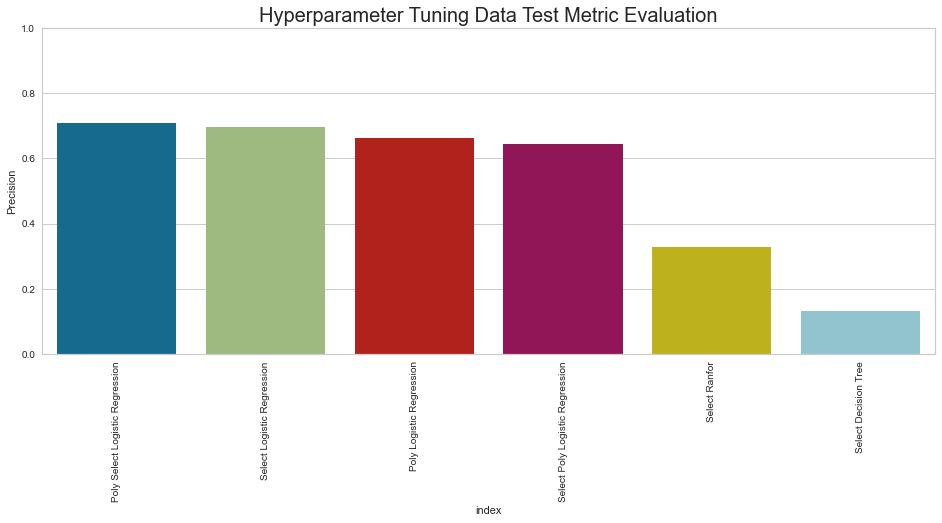

In [166]:
plt.figure(figsize=(16,6))
sns.barplot(x=metric_tuned['index'], y=metric_tuned['Precision'])
plt.xticks(rotation=90)
plt.title("Hyperparameter Tuning Data Test Metric Evaluation", size=20)
plt.ylim(0,1,4)
plt.show()